# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

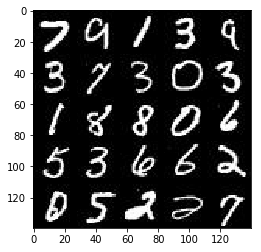

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

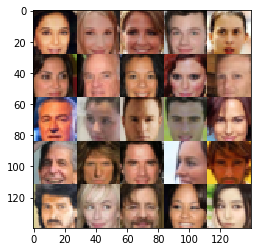

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def lrelu(x, alpha = 0.2, name='lrelu'):
    #with tf.variable_scope(name):
    f1 = 0.5*(1+alpha)
    f2 = 0.5*(1-alpha)
    return f1*x + f2*abs(x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    rate = 0.1
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28*28*3 -> 14*14*64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              # kernel_initializer = tf.random_normal_initializer(stddev=0.02))
                              kernel_initializer = tf.contrib.layers.xavier_initializer())
        # x1 = tf.maximum(0.2*x1, x1)
        x1 = lrelu(x1)
        # add drop out layer 
        x1 = tf.layers.dropout(x1, rate) 
        
        # 14*14*64 -> 7*7*128
        x2 = tf.layers.conv2d(x1, 128, 5, strides =2 , padding='same',
                              kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        # x2 = tf.maximum(0.2*x2, x2)
        x2 = lrelu(x2)
        x2 = tf.layers.dropout(x2, rate)
        
        # 7*7*128 -> 3*3*256
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', 
                              kernel_initializer = tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        # x3 = tf.maximum(0.2*x3, x3)
        x3 = lrelu(x3)
        x3 = tf.layers.dropout(x3, rate)
        
        # flatten 
        # s = x3.get_shape().as_list()
        # flat = tf.reshape(x3, (-1, s[1]*s[2]*s[3]))
        flat = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = True
    if is_train == True:
        reuse = False
    rate = 0.1
    with tf.variable_scope('generator', reuse=reuse):
        # z_dim -> 7*7*256
        # x = tf.layers.dense(z, 7*7*256)
        # x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.layers.dense(z, 2*2*512)
        x = tf.reshape(x, (-1, 2, 2, 512))
        
        # 7*7*256 -> 14*14*128
        # x2 = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same', 
        #                                kernel_initializer = tf.contrib.layers.xavier_initializer())
        # 7 * 7 * 256
        x2 = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='valid', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        s = x2.get_shape().as_list()
        # print('x2.shape {}'.format(s))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        # x2 = tf.maximum(0.2*x2, x2)
        x2 = lrelu(x2)
        x2 = tf.layers.dropout(x2, rate, training=is_train)
        
        # 14*14*128 -> 28*28*64
        # x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', 
        #                               kernel_initializer = tf.contrib.layers.xavier_initializer())
        # 14 * 14 * 128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        s = x3.get_shape().as_list()
        # print('x3.shape {}'.format(s))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        # x3 = tf.maximum(0.2*x3, x3)
        x3 = lrelu(x3)
        x3 = tf.layers.dropout(x3, rate, training=is_train)
        
        # 28*28*64 -> 28*28*3
        # logits = tf.layers.conv2d(x3, out_channel_dim, 5, strides=1, padding='same', 
        #                         kernel_initializer = tf.contrib.layers.xavier_initializer())
        # 28 * 28 * 3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', 
                                 kernel_initializer = tf.contrib.layers.xavier_initializer())
        s = logits.get_shape().as_list()
        # print('logits.shape {}'.format(s))
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        # tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*np.random.uniform(0.7, 1.2)))
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1.-smooth)))

    d_loss_fake = tf.reduce_mean(
 #       tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*np.random.uniform(0.0, 0.3)))
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*(1.-smooth)))

    g_loss = tf.reduce_mean(
        # tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*np.random.uniform(0.8, 1.0)))
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*(1.-smooth)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vts = tf.trainable_variables()
    d_v = [v for v in vts if v.name.startswith('discriminator')]
    g_v = [v for v in vts if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_v)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_v)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    # x = ((x - x.min())/(255 - x.min()))
    x = ((x - x.min())/(x.max() - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        # TODO: Build Model
    tf.reset_default_graph()
    (_, image_width, image_height, image_channels) = data_shape
    
    input_real, input_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every = 3
    show_every = epoch_count*30
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # scale input images 
                scale_images = scale(batch_images)
                
                # Run optimizer 
                _= sess.run(d_opt, feed_dict={input_z: batch_z, input_real: scale_images, l_rate: learning_rate})
                _= sess.run(g_opt, feed_dict={input_z: batch_z, input_real: scale_images, l_rate: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:scale_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7192... Generator Loss: 1.7600
Epoch 1/2... Discriminator Loss: 0.4397... Generator Loss: 2.6019
Epoch 1/2... Discriminator Loss: 0.5151... Generator Loss: 2.7455
Epoch 1/2... Discriminator Loss: 0.7093... Generator Loss: 2.0504
Epoch 1/2... Discriminator Loss: 1.7644... Generator Loss: 0.5465
Epoch 1/2... Discriminator Loss: 1.9256... Generator Loss: 0.4948
Epoch 1/2... Discriminator Loss: 0.7144... Generator Loss: 2.6240
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 3.5466
Epoch 1/2... Discriminator Loss: 2.5119... Generator Loss: 0.4347
Epoch 1/2... Discriminator Loss: 0.8748... Generator Loss: 1.7247
Epoch 1/2... Discriminator Loss: 1.6663... Generator Loss: 0.6253
Epoch 1/2... Discriminator Loss: 1.1875... Generator Loss: 3.9416
Epoch 1/2... Discriminator Loss: 0.7228... Generator Loss: 2.1307
Epoch 1/2... Discriminator Loss: 1.1552... Generator Loss: 1.0369
Epoch 1/2... Discriminator Loss: 1.5505... Generator Loss: 3.1207
Epoch 1/2.

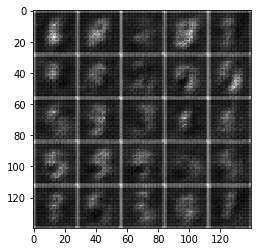

Epoch 1/2... Discriminator Loss: 0.9322... Generator Loss: 1.1770
Epoch 1/2... Discriminator Loss: 0.8418... Generator Loss: 1.2648
Epoch 1/2... Discriminator Loss: 1.4664... Generator Loss: 0.5547
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 1.8898
Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 2.4123
Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 0.9574
Epoch 1/2... Discriminator Loss: 0.8778... Generator Loss: 1.0752
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 1.4175
Epoch 1/2... Discriminator Loss: 0.9781... Generator Loss: 0.9805
Epoch 1/2... Discriminator Loss: 1.4941... Generator Loss: 2.7198
Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.1237
Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 1.0324
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 2.4047
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 0.7951
Epoch 1/2.

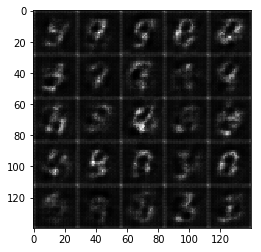

Epoch 1/2... Discriminator Loss: 1.1370... Generator Loss: 0.7662
Epoch 1/2... Discriminator Loss: 0.8573... Generator Loss: 1.1273
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 1.9431
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 1.4220
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.5753
Epoch 1/2... Discriminator Loss: 0.8864... Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 1.8289
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 0.7613
Epoch 1/2... Discriminator Loss: 0.7699... Generator Loss: 1.3725
Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 0.9844
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 2.2008
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.7248
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 1.9232
Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 0.8380
Epoch 1/2.

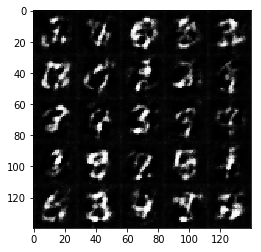

Epoch 1/2... Discriminator Loss: 0.7881... Generator Loss: 1.2841
Epoch 1/2... Discriminator Loss: 0.7307... Generator Loss: 2.1078
Epoch 1/2... Discriminator Loss: 0.8416... Generator Loss: 1.0042
Epoch 1/2... Discriminator Loss: 0.6615... Generator Loss: 1.6939
Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 3.0600
Epoch 1/2... Discriminator Loss: 0.8199... Generator Loss: 1.1398
Epoch 1/2... Discriminator Loss: 0.7118... Generator Loss: 1.3199
Epoch 1/2... Discriminator Loss: 0.7804... Generator Loss: 1.6536
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 1.1992
Epoch 1/2... Discriminator Loss: 0.8084... Generator Loss: 2.2267
Epoch 1/2... Discriminator Loss: 0.7807... Generator Loss: 1.1365
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 3.0240
Epoch 1/2... Discriminator Loss: 0.7824... Generator Loss: 1.1210
Epoch 1/2.

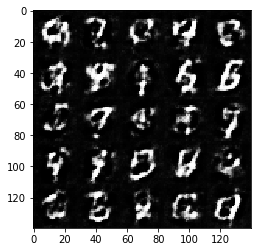

Epoch 1/2... Discriminator Loss: 0.7898... Generator Loss: 1.1180
Epoch 1/2... Discriminator Loss: 0.8380... Generator Loss: 2.2511
Epoch 1/2... Discriminator Loss: 0.7252... Generator Loss: 1.2225
Epoch 1/2... Discriminator Loss: 0.7655... Generator Loss: 1.6253
Epoch 1/2... Discriminator Loss: 0.7501... Generator Loss: 1.1268
Epoch 1/2... Discriminator Loss: 0.8325... Generator Loss: 1.8822
Epoch 1/2... Discriminator Loss: 0.9187... Generator Loss: 0.9147
Epoch 1/2... Discriminator Loss: 0.7900... Generator Loss: 1.3290
Epoch 1/2... Discriminator Loss: 0.8937... Generator Loss: 0.9194
Epoch 1/2... Discriminator Loss: 0.9910... Generator Loss: 2.8296
Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 0.7260
Epoch 1/2... Discriminator Loss: 0.8243... Generator Loss: 1.5868
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.9442
Epoch 1/2... Discriminator Loss: 0.8994... Generator Loss: 1.0771
Epoch 1/2... Discriminator Loss: 0.8993... Generator Loss: 1.0156
Epoch 1/2.

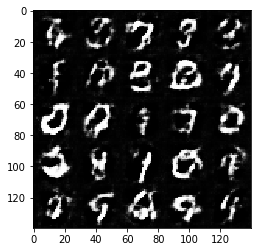

Epoch 1/2... Discriminator Loss: 0.9325... Generator Loss: 2.6356
Epoch 1/2... Discriminator Loss: 0.7212... Generator Loss: 1.6835
Epoch 1/2... Discriminator Loss: 1.1302... Generator Loss: 0.7713
Epoch 1/2... Discriminator Loss: 0.7177... Generator Loss: 1.8775
Epoch 1/2... Discriminator Loss: 1.0950... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.7865... Generator Loss: 3.2247
Epoch 1/2... Discriminator Loss: 0.7685... Generator Loss: 1.5440
Epoch 1/2... Discriminator Loss: 0.8391... Generator Loss: 1.0678
Epoch 1/2... Discriminator Loss: 1.0099... Generator Loss: 0.7962
Epoch 1/2... Discriminator Loss: 0.7582... Generator Loss: 1.4134
Epoch 1/2... Discriminator Loss: 0.8397... Generator Loss: 1.1334
Epoch 1/2... Discriminator Loss: 0.9957... Generator Loss: 2.2520
Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 0.9870
Epoch 1/2... Discriminator Loss: 0.8777... Generator Loss: 0.9817
Epoch 1/2... Discriminator Loss: 0.7880... Generator Loss: 2.1439
Epoch 1/2.

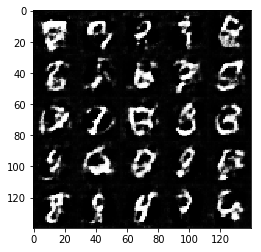

Epoch 1/2... Discriminator Loss: 0.9406... Generator Loss: 0.8442
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 2.0499
Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 0.9535
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 2.6808
Epoch 1/2... Discriminator Loss: 0.7481... Generator Loss: 1.2709
Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 0.8948
Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 0.7425
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 2.3304
Epoch 1/2... Discriminator Loss: 0.7121... Generator Loss: 1.5834
Epoch 1/2... Discriminator Loss: 0.7852... Generator Loss: 1.1713
Epoch 1/2... Discriminator Loss: 0.7281... Generator Loss: 1.3443
Epoch 1/2... Discriminator Loss: 0.7907... Generator Loss: 1.5584
Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 1.1950
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 2.8813
Epoch 1/2.

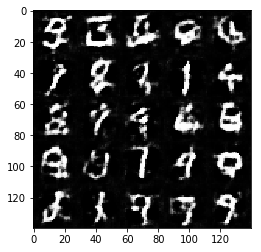

Epoch 1/2... Discriminator Loss: 0.7540... Generator Loss: 1.3226
Epoch 1/2... Discriminator Loss: 0.7161... Generator Loss: 1.3970
Epoch 1/2... Discriminator Loss: 1.1525... Generator Loss: 0.7868
Epoch 1/2... Discriminator Loss: 0.6811... Generator Loss: 1.5592
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 0.7210
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 2.4105
Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 0.8102... Generator Loss: 1.3927
Epoch 1/2... Discriminator Loss: 0.7436... Generator Loss: 1.2799
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 0.8806
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 1.9480
Epoch 1/2... Discriminator Loss: 0.9163... Generator Loss: 0.9887
Epoch 1/2... Discriminator Loss: 0.7883... Generator Loss: 1.5955
Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 1.4224
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.6412
Epoch 1/2.

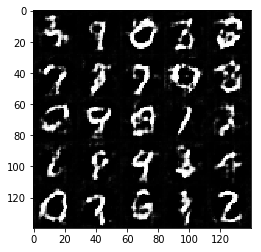

Epoch 1/2... Discriminator Loss: 1.2304... Generator Loss: 2.6887
Epoch 1/2... Discriminator Loss: 0.8120... Generator Loss: 1.1730
Epoch 1/2... Discriminator Loss: 0.9333... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 0.7000... Generator Loss: 1.9286
Epoch 1/2... Discriminator Loss: 1.3529... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 1.5385
Epoch 1/2... Discriminator Loss: 0.7455... Generator Loss: 1.8149
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 1.0556
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 1.6690
Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 0.7919
Epoch 1/2... Discriminator Loss: 1.0075... Generator Loss: 2.0999
Epoch 1/2... Discriminator Loss: 0.8810... Generator Loss: 0.9892
Epoch 1/2... Discriminator Loss: 0.7698... Generator Loss: 1.5978
Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 0.8172
Epoch 1/2.

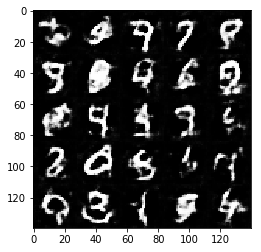

Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 0.8973... Generator Loss: 1.8978
Epoch 1/2... Discriminator Loss: 0.9302... Generator Loss: 0.8916
Epoch 1/2... Discriminator Loss: 0.7309... Generator Loss: 1.6245
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 0.9279
Epoch 1/2... Discriminator Loss: 0.7811... Generator Loss: 1.3081
Epoch 1/2... Discriminator Loss: 0.9403... Generator Loss: 0.8800
Epoch 1/2... Discriminator Loss: 1.5760... Generator Loss: 3.1387
Epoch 1/2... Discriminator Loss: 0.8212... Generator Loss: 1.2040
Epoch 1/2... Discriminator Loss: 0.7329... Generator Loss: 1.4462
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 1.0428
Epoch 1/2... Discriminator Loss: 0.7988... Generator Loss: 1.1753
Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 2.4885
Epoch 1/2... Discriminator Loss: 0.8833... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 2.3984
Epoch 1/2.

Epoch 1/2... Discriminator Loss: 0.8233... Generator Loss: 1.0192
Epoch 1/2... Discriminator Loss: 0.8814... Generator Loss: 1.7855
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.4623
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.6522
Epoch 1/2... Discriminator Loss: 0.7715... Generator Loss: 1.6825
Epoch 1/2... Discriminator Loss: 0.7614... Generator Loss: 1.6297
Epoch 1/2... Discriminator Loss: 0.7968... Generator Loss: 1.3136
Epoch 1/2... Discriminator Loss: 0.9591... Generator Loss: 2.1532
Epoch 1/2... Discriminator Loss: 0.6993... Generator Loss: 1.4769
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 1.2251
Epoch 1/2... Discriminator Loss: 0.7756... Generator Loss: 1.5287
Epoch 1/2... Discriminator Loss: 0.7947... Generator Loss: 1.6150
Epoch 1/2... Discriminator Loss: 1.4552... Generator Loss: 0.5765
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 1.0982
Epoch 1/2... Discriminator Loss: 0.8045... Generator Loss: 1.5805
Epoch 1/2.

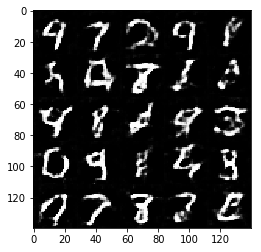

Epoch 1/2... Discriminator Loss: 0.7134... Generator Loss: 1.8492
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 0.9095
Epoch 1/2... Discriminator Loss: 0.8116... Generator Loss: 2.1314
Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 1.4681
Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 0.6056
Epoch 1/2... Discriminator Loss: 0.7963... Generator Loss: 1.4359
Epoch 1/2... Discriminator Loss: 0.8964... Generator Loss: 1.0215
Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 1.2247
Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 1.0505
Epoch 1/2... Discriminator Loss: 1.0378... Generator Loss: 0.8513
Epoch 1/2... Discriminator Loss: 1.0951... Generator Loss: 2.5468
Epoch 1/2... Discriminator Loss: 0.7119... Generator Loss: 1.6535
Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 0.6889
Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 2.0242
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 2.3825
Epoch 1/2.

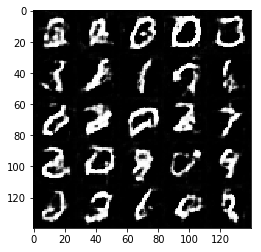

Epoch 1/2... Discriminator Loss: 0.7104... Generator Loss: 1.3108
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 1.1945
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 1.6416
Epoch 1/2... Discriminator Loss: 0.7480... Generator Loss: 1.2516
Epoch 1/2... Discriminator Loss: 0.7284... Generator Loss: 1.1901
Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 1.0442
Epoch 1/2... Discriminator Loss: 0.8661... Generator Loss: 2.6942
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 0.7502
Epoch 1/2... Discriminator Loss: 0.9176... Generator Loss: 2.0670
Epoch 1/2... Discriminator Loss: 1.0266... Generator Loss: 3.1504
Epoch 1/2... Discriminator Loss: 1.4904... Generator Loss: 0.5466
Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 1.7215
Epoch 1/2... Discriminator Loss: 0.8357... Generator Loss: 1.1172
Epoch 1/2... Discriminator Loss: 0.7852... Generator Loss: 1.1879
Epoch 1/2... Discriminator Loss: 0.7103... Generator Loss: 1.4804
Epoch 1/2.

Epoch 1/2... Discriminator Loss: 0.6831... Generator Loss: 1.2528
Epoch 1/2... Discriminator Loss: 1.0009... Generator Loss: 2.8586
Epoch 1/2... Discriminator Loss: 0.7833... Generator Loss: 1.1660
Epoch 1/2... Discriminator Loss: 0.7373... Generator Loss: 1.1828
Epoch 1/2... Discriminator Loss: 0.6378... Generator Loss: 1.8154
Epoch 1/2... Discriminator Loss: 0.6698... Generator Loss: 1.6329
Epoch 1/2... Discriminator Loss: 0.6754... Generator Loss: 1.4245
Epoch 1/2... Discriminator Loss: 0.6103... Generator Loss: 1.5980
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 2.4226
Epoch 1/2... Discriminator Loss: 0.8681... Generator Loss: 1.1089
Epoch 1/2... Discriminator Loss: 0.7683... Generator Loss: 1.5317
Epoch 1/2... Discriminator Loss: 0.5965... Generator Loss: 1.8317
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 0.6196... Generator Loss: 1.5720
Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 0.9575
Epoch 1/2.

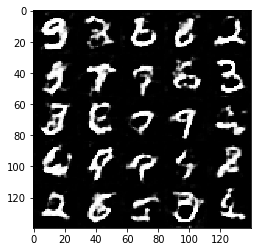

Epoch 1/2... Discriminator Loss: 0.6591... Generator Loss: 1.5342
Epoch 1/2... Discriminator Loss: 0.6627... Generator Loss: 2.0606
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.6681
Epoch 1/2... Discriminator Loss: 2.9128... Generator Loss: 4.3897
Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 1.0681
Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 0.8887
Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 1.0075
Epoch 1/2... Discriminator Loss: 0.8201... Generator Loss: 1.0852
Epoch 1/2... Discriminator Loss: 0.6964... Generator Loss: 1.2915
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 1.0592
Epoch 1/2... Discriminator Loss: 0.7405... Generator Loss: 1.2472
Epoch 1/2... Discriminator Loss: 0.7062... Generator Loss: 2.0327
Epoch 2/2... Discriminator Loss: 0.6482... Generator Loss: 1.9094
Epoch 2/2... Discriminator Loss: 0.6336... Generator Loss: 1.9187
Epoch 2/2... Discriminator Loss: 0.6646... Generator Loss: 1.9111
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 0.6637... Generator Loss: 1.3954
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 1.0880
Epoch 2/2... Discriminator Loss: 0.6299... Generator Loss: 1.4330
Epoch 2/2... Discriminator Loss: 0.6583... Generator Loss: 1.2968
Epoch 2/2... Discriminator Loss: 0.6505... Generator Loss: 1.5197
Epoch 2/2... Discriminator Loss: 0.5568... Generator Loss: 1.6068
Epoch 2/2... Discriminator Loss: 1.0814... Generator Loss: 0.7718
Epoch 2/2... Discriminator Loss: 0.6620... Generator Loss: 1.9086
Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 1.2301
Epoch 2/2... Discriminator Loss: 0.8021... Generator Loss: 1.1462
Epoch 2/2... Discriminator Loss: 0.5883... Generator Loss: 1.9864
Epoch 2/2... Discriminator Loss: 0.6029... Generator Loss: 1.8218
Epoch 2/2... Discriminator Loss: 0.6080... Generator Loss: 1.5135
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 1.0510
Epoch 2/2... Discriminator Loss: 0.6858... Generator Loss: 1.3232
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 0.6770... Generator Loss: 1.3969
Epoch 2/2... Discriminator Loss: 0.8310... Generator Loss: 2.5525
Epoch 2/2... Discriminator Loss: 1.4991... Generator Loss: 0.6355
Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 1.4888
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 1.6635
Epoch 2/2... Discriminator Loss: 0.7353... Generator Loss: 1.3928
Epoch 2/2... Discriminator Loss: 0.6001... Generator Loss: 2.0008
Epoch 2/2... Discriminator Loss: 0.6366... Generator Loss: 1.8955
Epoch 2/2... Discriminator Loss: 0.6033... Generator Loss: 1.8557
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 2.2277
Epoch 2/2... Discriminator Loss: 0.6222... Generator Loss: 1.8392
Epoch 2/2... Discriminator Loss: 0.6287... Generator Loss: 1.7237
Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.5797
Epoch 2/2... Discriminator Loss: 0.5307... Generator Loss: 1.9437
Epoch 2/2... Discriminator Loss: 0.6853... Generator Loss: 1.3308
Epoch 2/2.

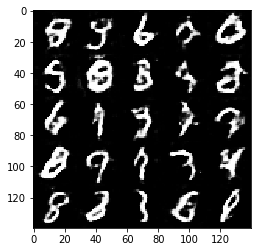

Epoch 2/2... Discriminator Loss: 0.6369... Generator Loss: 1.8929
Epoch 2/2... Discriminator Loss: 0.5876... Generator Loss: 1.7082
Epoch 2/2... Discriminator Loss: 0.6624... Generator Loss: 2.4852
Epoch 2/2... Discriminator Loss: 0.5461... Generator Loss: 2.0757
Epoch 2/2... Discriminator Loss: 0.5928... Generator Loss: 2.0121
Epoch 2/2... Discriminator Loss: 0.5420... Generator Loss: 1.7864
Epoch 2/2... Discriminator Loss: 0.5347... Generator Loss: 2.0812
Epoch 2/2... Discriminator Loss: 0.6195... Generator Loss: 1.5398
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.2117
Epoch 2/2... Discriminator Loss: 0.5263... Generator Loss: 1.8505
Epoch 2/2... Discriminator Loss: 0.5628... Generator Loss: 1.9488
Epoch 2/2... Discriminator Loss: 0.5189... Generator Loss: 2.4055
Epoch 2/2... Discriminator Loss: 0.8295... Generator Loss: 1.1574
Epoch 2/2... Discriminator Loss: 0.5513... Generator Loss: 2.0616
Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.2062
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 1.3422
Epoch 2/2... Discriminator Loss: 0.7713... Generator Loss: 2.2876
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 1.2875
Epoch 2/2... Discriminator Loss: 0.6926... Generator Loss: 1.3524
Epoch 2/2... Discriminator Loss: 0.6682... Generator Loss: 1.3864
Epoch 2/2... Discriminator Loss: 0.6220... Generator Loss: 1.5064
Epoch 2/2... Discriminator Loss: 0.5058... Generator Loss: 2.1069
Epoch 2/2... Discriminator Loss: 0.6075... Generator Loss: 1.8147
Epoch 2/2... Discriminator Loss: 0.7121... Generator Loss: 1.2307
Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 1.4678
Epoch 2/2... Discriminator Loss: 0.6014... Generator Loss: 1.8407
Epoch 2/2... Discriminator Loss: 0.5890... Generator Loss: 1.5973
Epoch 2/2... Discriminator Loss: 0.7189... Generator Loss: 1.2194
Epoch 2/2... Discriminator Loss: 0.6364... Generator Loss: 1.3519
Epoch 2/2... Discriminator Loss: 0.5845... Generator Loss: 1.7457
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 1.2014
Epoch 2/2... Discriminator Loss: 0.7177... Generator Loss: 1.1642
Epoch 2/2... Discriminator Loss: 0.6436... Generator Loss: 1.3046
Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.2579
Epoch 2/2... Discriminator Loss: 0.7059... Generator Loss: 1.3003
Epoch 2/2... Discriminator Loss: 0.5235... Generator Loss: 1.8576
Epoch 2/2... Discriminator Loss: 0.6101... Generator Loss: 1.5825
Epoch 2/2... Discriminator Loss: 0.6378... Generator Loss: 1.7470
Epoch 2/2... Discriminator Loss: 0.5855... Generator Loss: 1.5936
Epoch 2/2... Discriminator Loss: 0.5767... Generator Loss: 1.7428
Epoch 2/2... Discriminator Loss: 0.6817... Generator Loss: 1.2861
Epoch 2/2... Discriminator Loss: 0.6869... Generator Loss: 1.2112
Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 1.8514
Epoch 2/2... Discriminator Loss: 0.5747... Generator Loss: 1.6827
Epoch 2/2... Discriminator Loss: 0.5229... Generator Loss: 1.9299
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 0.5226... Generator Loss: 2.2642
Epoch 2/2... Discriminator Loss: 0.5904... Generator Loss: 1.8863
Epoch 2/2... Discriminator Loss: 0.5304... Generator Loss: 1.7378
Epoch 2/2... Discriminator Loss: 0.5331... Generator Loss: 1.7309
Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 1.1880
Epoch 2/2... Discriminator Loss: 0.5655... Generator Loss: 2.0768
Epoch 2/2... Discriminator Loss: 0.4970... Generator Loss: 2.1717
Epoch 2/2... Discriminator Loss: 0.9161... Generator Loss: 1.0032
Epoch 2/2... Discriminator Loss: 2.3825... Generator Loss: 4.2162
Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 1.1567
Epoch 2/2... Discriminator Loss: 0.7546... Generator Loss: 1.7783
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 0.6587... Generator Loss: 1.4607
Epoch 2/2... Discriminator Loss: 0.6538... Generator Loss: 1.6202
Epoch 2/2... Discriminator Loss: 0.5613... Generator Loss: 1.8168
Epoch 2/2.

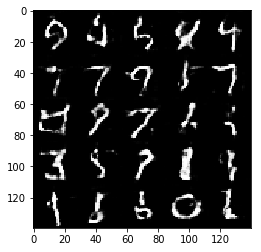

Epoch 2/2... Discriminator Loss: 0.5351... Generator Loss: 1.9399
Epoch 2/2... Discriminator Loss: 0.5675... Generator Loss: 1.6747
Epoch 2/2... Discriminator Loss: 0.5798... Generator Loss: 1.4758
Epoch 2/2... Discriminator Loss: 0.6839... Generator Loss: 1.8277
Epoch 2/2... Discriminator Loss: 0.5680... Generator Loss: 1.9424
Epoch 2/2... Discriminator Loss: 0.5915... Generator Loss: 2.2960
Epoch 2/2... Discriminator Loss: 0.7089... Generator Loss: 1.6316
Epoch 2/2... Discriminator Loss: 0.6339... Generator Loss: 1.3462
Epoch 2/2... Discriminator Loss: 0.5439... Generator Loss: 1.7622
Epoch 2/2... Discriminator Loss: 0.6188... Generator Loss: 2.7957
Epoch 2/2... Discriminator Loss: 1.3888... Generator Loss: 0.5952
Epoch 2/2... Discriminator Loss: 6.3293... Generator Loss: 7.8892
Epoch 2/2... Discriminator Loss: 2.2840... Generator Loss: 4.1080
Epoch 2/2... Discriminator Loss: 0.9589... Generator Loss: 2.2093
Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 1.0982
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 0.5571... Generator Loss: 1.6806
Epoch 2/2... Discriminator Loss: 0.6655... Generator Loss: 1.4857
Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.6901
Epoch 2/2... Discriminator Loss: 0.6189... Generator Loss: 1.4885
Epoch 2/2... Discriminator Loss: 0.5673... Generator Loss: 1.6549
Epoch 2/2... Discriminator Loss: 0.5134... Generator Loss: 1.9010
Epoch 2/2... Discriminator Loss: 0.5528... Generator Loss: 1.8202
Epoch 2/2... Discriminator Loss: 0.5931... Generator Loss: 1.5979
Epoch 2/2... Discriminator Loss: 0.6021... Generator Loss: 1.5300
Epoch 2/2... Discriminator Loss: 0.5386... Generator Loss: 1.8506
Epoch 2/2... Discriminator Loss: 0.5608... Generator Loss: 1.7649
Epoch 2/2... Discriminator Loss: 0.5966... Generator Loss: 1.6017
Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 1.6457
Epoch 2/2... Discriminator Loss: 0.5678... Generator Loss: 1.8576
Epoch 2/2... Discriminator Loss: 0.5696... Generator Loss: 2.1464
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 0.6746... Generator Loss: 1.3473
Epoch 2/2... Discriminator Loss: 0.5868... Generator Loss: 1.5325
Epoch 2/2... Discriminator Loss: 0.6327... Generator Loss: 1.4572
Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.4645
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 1.1997
Epoch 2/2... Discriminator Loss: 0.7954... Generator Loss: 1.0124
Epoch 2/2... Discriminator Loss: 0.6351... Generator Loss: 1.3329
Epoch 2/2... Discriminator Loss: 0.5486... Generator Loss: 1.7661
Epoch 2/2... Discriminator Loss: 0.5668... Generator Loss: 1.8165
Epoch 2/2... Discriminator Loss: 0.5210... Generator Loss: 1.8148
Epoch 2/2... Discriminator Loss: 0.5952... Generator Loss: 1.7016
Epoch 2/2... Discriminator Loss: 0.5393... Generator Loss: 1.8757
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 1.3964
Epoch 2/2... Discriminator Loss: 0.5176... Generator Loss: 2.0031
Epoch 2/2... Discriminator Loss: 0.5644... Generator Loss: 1.6565
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 0.5371... Generator Loss: 1.7862
Epoch 2/2... Discriminator Loss: 0.5552... Generator Loss: 1.7568
Epoch 2/2... Discriminator Loss: 0.5703... Generator Loss: 1.5652
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 0.9186
Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 2.1968
Epoch 2/2... Discriminator Loss: 3.3800... Generator Loss: 0.3880
Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 2.2588
Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 2.2651
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 2.2726
Epoch 2/2... Discriminator Loss: 0.6775... Generator Loss: 2.2035
Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 1.0775
Epoch 2/2... Discriminator Loss: 0.6310... Generator Loss: 1.4915
Epoch 2/2... Discriminator Loss: 0.5730... Generator Loss: 1.9517
Epoch 2/2... Discriminator Loss: 0.6774... Generator Loss: 1.1823
Epoch 2/2... Discriminator Loss: 0.6250... Generator Loss: 1.4097
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 0.5333... Generator Loss: 1.8328
Epoch 2/2... Discriminator Loss: 0.5553... Generator Loss: 2.1438
Epoch 2/2... Discriminator Loss: 0.5524... Generator Loss: 1.8785
Epoch 2/2... Discriminator Loss: 0.6687... Generator Loss: 2.2205
Epoch 2/2... Discriminator Loss: 0.5086... Generator Loss: 1.9159
Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 1.6774
Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 1.2322
Epoch 2/2... Discriminator Loss: 0.5975... Generator Loss: 1.4516
Epoch 2/2... Discriminator Loss: 0.6128... Generator Loss: 1.5992
Epoch 2/2... Discriminator Loss: 0.5418... Generator Loss: 1.5766
Epoch 2/2... Discriminator Loss: 0.6135... Generator Loss: 1.4864
Epoch 2/2... Discriminator Loss: 0.6885... Generator Loss: 1.2251
Epoch 2/2... Discriminator Loss: 0.8020... Generator Loss: 1.0915
Epoch 2/2... Discriminator Loss: 3.8464... Generator Loss: 6.4586
Epoch 2/2... Discriminator Loss: 1.6880... Generator Loss: 0.5424
Epoch 2/2.

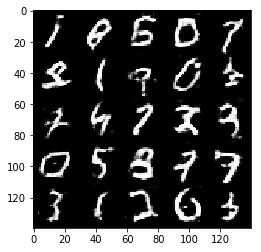

Epoch 2/2... Discriminator Loss: 0.5656... Generator Loss: 1.9025
Epoch 2/2... Discriminator Loss: 0.7142... Generator Loss: 1.2024
Epoch 2/2... Discriminator Loss: 0.5462... Generator Loss: 1.8007
Epoch 2/2... Discriminator Loss: 0.5518... Generator Loss: 1.7638
Epoch 2/2... Discriminator Loss: 0.5589... Generator Loss: 1.6430
Epoch 2/2... Discriminator Loss: 0.5423... Generator Loss: 2.0563
Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 1.3916
Epoch 2/2... Discriminator Loss: 0.5119... Generator Loss: 1.9828
Epoch 2/2... Discriminator Loss: 0.5550... Generator Loss: 1.6729
Epoch 2/2... Discriminator Loss: 0.5945... Generator Loss: 1.4801
Epoch 2/2... Discriminator Loss: 0.6184... Generator Loss: 1.3793
Epoch 2/2... Discriminator Loss: 0.5820... Generator Loss: 1.8741
Epoch 2/2... Discriminator Loss: 0.7625... Generator Loss: 1.1342
Epoch 2/2... Discriminator Loss: 0.4829... Generator Loss: 1.9823
Epoch 2/2... Discriminator Loss: 0.7302... Generator Loss: 1.1659
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 0.6452... Generator Loss: 1.6328
Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 1.2866
Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 1.9118
Epoch 2/2... Discriminator Loss: 0.6007... Generator Loss: 1.5267
Epoch 2/2... Discriminator Loss: 0.5052... Generator Loss: 2.1998
Epoch 2/2... Discriminator Loss: 0.5566... Generator Loss: 1.7216
Epoch 2/2... Discriminator Loss: 0.7695... Generator Loss: 1.0922
Epoch 2/2... Discriminator Loss: 1.5151... Generator Loss: 3.5190
Epoch 2/2... Discriminator Loss: 0.8877... Generator Loss: 1.4257
Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 1.0618
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 0.7210... Generator Loss: 1.3833
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 0.8421
Epoch 2/2... Discriminator Loss: 0.7986... Generator Loss: 1.9532
Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 1.5826
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 0.6797... Generator Loss: 1.3473
Epoch 2/2... Discriminator Loss: 0.8372... Generator Loss: 1.0219
Epoch 2/2... Discriminator Loss: 0.6308... Generator Loss: 1.5460
Epoch 2/2... Discriminator Loss: 0.5272... Generator Loss: 1.9801
Epoch 2/2... Discriminator Loss: 0.6494... Generator Loss: 1.4220
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 1.3505
Epoch 2/2... Discriminator Loss: 0.8094... Generator Loss: 1.1596
Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 2.9124
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 2.5255
Epoch 2/2... Discriminator Loss: 0.6782... Generator Loss: 1.6118
Epoch 2/2... Discriminator Loss: 0.5903... Generator Loss: 1.9575
Epoch 2/2... Discriminator Loss: 0.6645... Generator Loss: 1.3005
Epoch 2/2... Discriminator Loss: 0.6776... Generator Loss: 1.3193
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 1.5073
Epoch 2/2... Discriminator Loss: 0.5057... Generator Loss: 2.0876
Epoch 2/2.

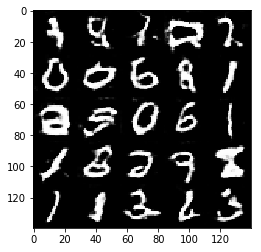

Epoch 2/2... Discriminator Loss: 0.6295... Generator Loss: 1.3767
Epoch 2/2... Discriminator Loss: 0.5500... Generator Loss: 1.7366
Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 1.2636
Epoch 2/2... Discriminator Loss: 0.6543... Generator Loss: 1.3160
Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 2.5267
Epoch 2/2... Discriminator Loss: 0.5801... Generator Loss: 1.9235
Epoch 2/2... Discriminator Loss: 0.5969... Generator Loss: 1.4038
Epoch 2/2... Discriminator Loss: 0.6182... Generator Loss: 1.6429
Epoch 2/2... Discriminator Loss: 0.6230... Generator Loss: 1.5477
Epoch 2/2... Discriminator Loss: 0.6088... Generator Loss: 1.4606
Epoch 2/2... Discriminator Loss: 0.5414... Generator Loss: 1.6391
Epoch 2/2... Discriminator Loss: 0.5180... Generator Loss: 2.0811
Epoch 2/2... Discriminator Loss: 0.5270... Generator Loss: 1.7765
Epoch 2/2... Discriminator Loss: 0.5962... Generator Loss: 1.5544
Epoch 2/2... Discriminator Loss: 0.5148... Generator Loss: 2.5566
Epoch 2/2.

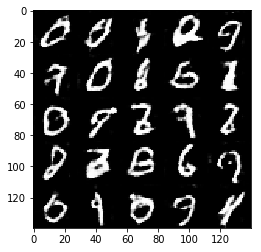

Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 0.6671
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.1958
Epoch 2/2... Discriminator Loss: 0.7730... Generator Loss: 1.2158
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 0.9205


IndexError: list index out of range

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 1.7266
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 1.8704
Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 2.4226
Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 2.0992
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 2.2794
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 2.8703
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 2.7816
Epoch 1/1... Discriminator Loss: 0.6077... Generator Loss: 1.7758


Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 2.4432
Epoch 1/1... Discriminator Loss: 1.6361... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 3.0517
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 2.0629
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 1.4752
Epoch 1/1... Discriminator Loss: 1.8387... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.2693
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 1.3067


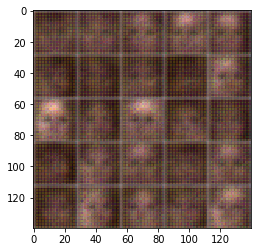

Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.4789
Epoch 1/1... Discriminator Loss: 1.7679... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.9820
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 2.7156
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.2090
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 3.2667
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.4668


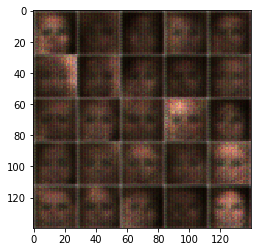

Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.9260
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.5521
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.8342
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 1.4118
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 0.6497... Generator Loss: 2.3512
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 1.9848
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.3204


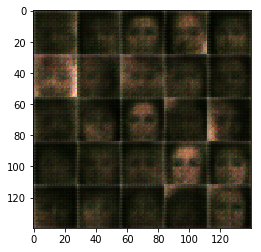

Epoch 1/1... Discriminator Loss: 0.7080... Generator Loss: 1.5438
Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 2.5307
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 1.2750
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 2.0195
Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 1.5628
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 3.0080
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 1.5771
Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 2.0333


Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.4974
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 2.8104
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 2.2240
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.4072
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 1.9720
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.7218


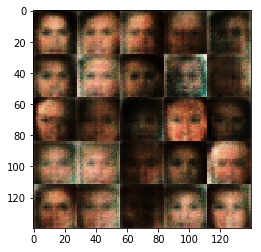

Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 3.5092
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 1.3439
Epoch 1/1... Discriminator Loss: 0.7278... Generator Loss: 1.3511
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.7288
Epoch 1/1... Discriminator Loss: 0.7283... Generator Loss: 1.9222
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 1.4486
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 1.3296
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 2.4622
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 0.8132


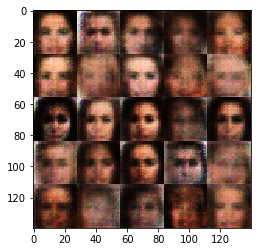

Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 2.1865
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 1.6927
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 0.6627... Generator Loss: 1.6257
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 2.9366
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.7187
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 1.5097
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 2.1060


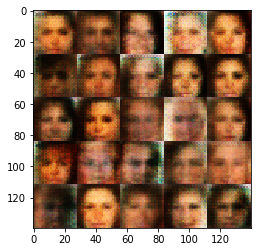

Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 1.3171
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.5372
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 0.8457... Generator Loss: 1.2651
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 2.2500
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 2.5628


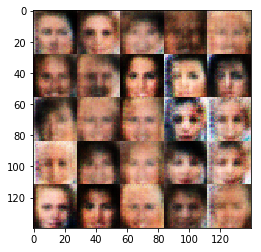

Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 2.1463
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 1.6069
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 1.2005
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 2.6682
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 1.2986
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 1.8735
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.1638
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.8220


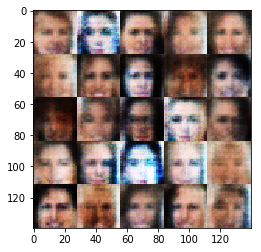

Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.9791
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 2.4412
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.6932
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.5694
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 1.4080
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 2.3715
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.7255


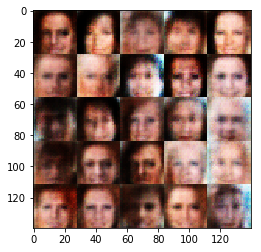

Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 1.7986
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 2.1956
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 1.8913
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.2856
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 2.3692
Epoch 1/1... Discriminator Loss: 0.8854... Generator Loss: 1.0624


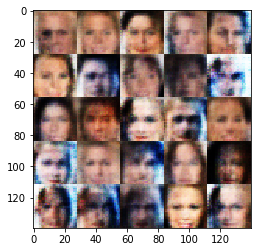

Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 2.1449
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.5444
Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 1.1277
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.8121
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 2.2486... Generator Loss: 3.1397
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 1.1948


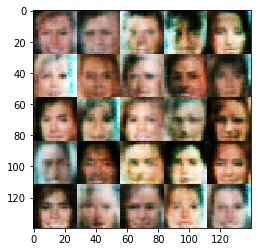

Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 1.8635
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.4336
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 1.0962
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.2855
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.2877
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 1.9375


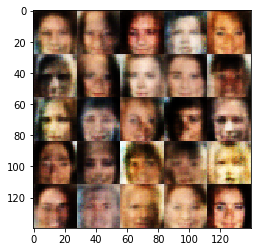

Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.9905
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 1.6752
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 2.2734
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 1.5539


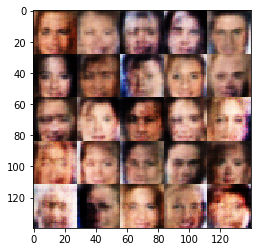

Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.4821
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.0914
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 2.2160
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.1907
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 1.8664


Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.6984
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 1.1327
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.2988
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.3650


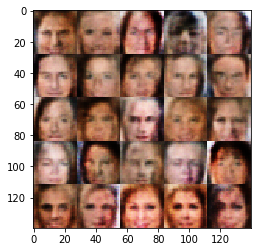

Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 2.0305... Generator Loss: 3.7230
Epoch 1/1... Discriminator Loss: 1.6472... Generator Loss: 0.4686
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.5049
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.1341
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 1.4760
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.1153


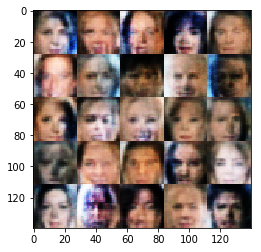

Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 1.6131
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.4151
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 1.4839
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.1535


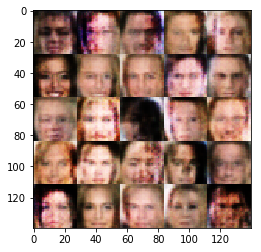

Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 1.9484
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 2.2866
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.8838


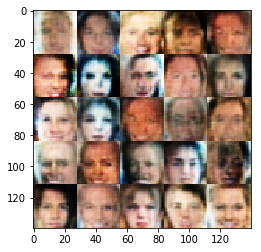

Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.6004... Generator Loss: 2.2478
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 1.5600
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.4976
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.6007


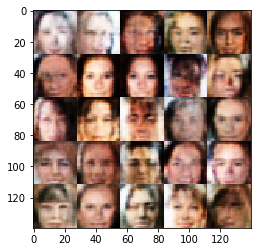

Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 2.0204
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 1.4841
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.2978
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.6121
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.8355


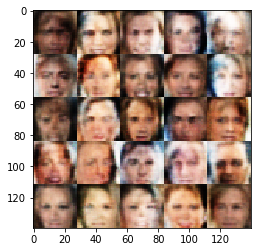

Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 1.9206
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 2.2057
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.5482
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 2.1607
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.2107
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.2489


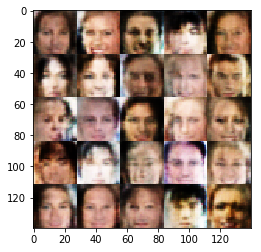

Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.2547
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 2.4017
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.9085
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 1.5527
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.8765
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.9610


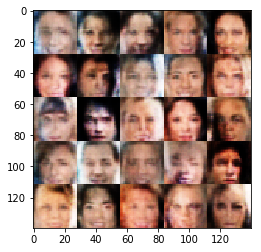

Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 1.4683
Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 1.8870
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.6920
Epoch 1/1... Discriminator Loss: 0.7870... Generator Loss: 1.9726
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 1.1943
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.6786
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.1350


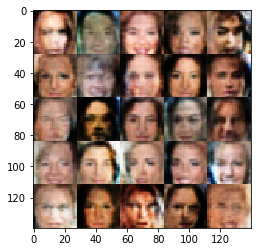

Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.7416
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 1.9477
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 2.4797
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 1.9122
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.8624


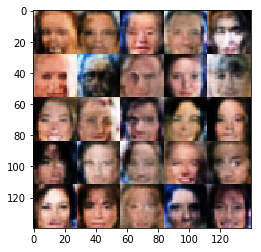

Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 2.5995
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 0.8038... Generator Loss: 2.5743
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.3163
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 1.4128
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 1.5207
Epoch 1/1... Discriminator Loss: 0.7595... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.8191


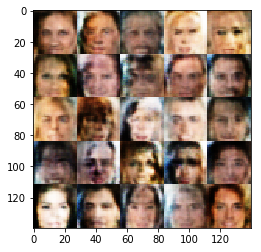

Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 2.3292
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 0.6002... Generator Loss: 1.5345
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.2182


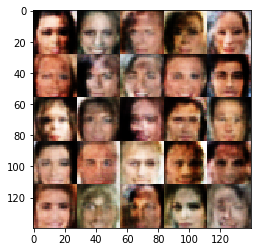

Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.9312
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 2.0487
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 0.6814... Generator Loss: 1.6261
Epoch 1/1... Discriminator Loss: 0.7505... Generator Loss: 1.3513
Epoch 1/1... Discriminator Loss: 0.7712... Generator Loss: 1.1958
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.8212
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.2779
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 2.8294


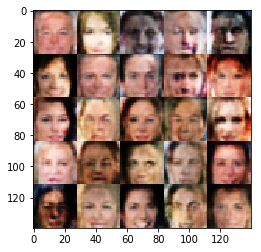

Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 2.1103... Generator Loss: 2.7005
Epoch 1/1... Discriminator Loss: 1.6142... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 1.5816
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 1.9073
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.3850


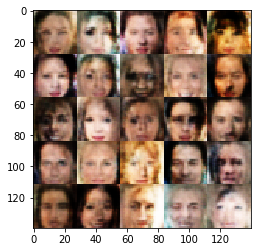

Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.6666
Epoch 1/1... Discriminator Loss: 0.6826... Generator Loss: 1.7535
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 1.2289
Epoch 1/1... Discriminator Loss: 0.7370... Generator Loss: 1.3729
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.9610
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.8538


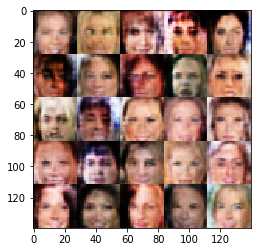

Epoch 1/1... Discriminator Loss: 3.3764... Generator Loss: 3.3486
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 1.7917
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.7154
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 2.2250


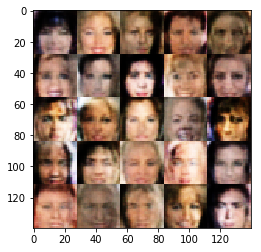

Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 1.9655
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 1.5257
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.5713
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.8886
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.1731
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.7518
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 2.0251
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 1.0583
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.2546


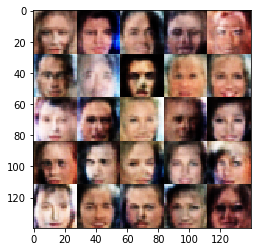

Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.2517
Epoch 1/1... Discriminator Loss: 0.7849... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 0.5742... Generator Loss: 2.0230
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.2961
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 1.8298
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 1.6533
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.4816
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 1.1857


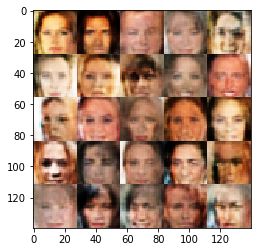

Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.5381
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 2.1560
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 2.0852
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.9043
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.9485
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.1105
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 2.1510
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.5238


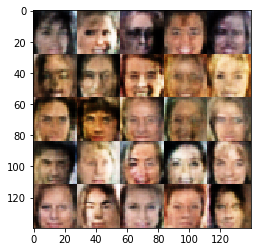

Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 1.5551
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.1433
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.8293
Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 1.6312
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 2.0694
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 1.3665


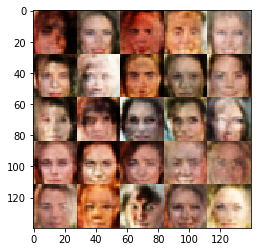

Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 0.6278... Generator Loss: 1.4408
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.1434
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 2.4131
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.2171
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 1.4280


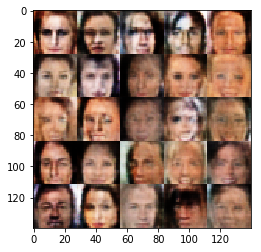

Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 1.9612
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 2.4325
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.2600
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 2.1042
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.1739
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.9025


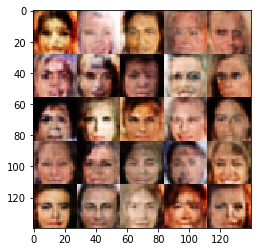

Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 2.5331
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 1.9166
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 1.4990
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.5267
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 0.9230


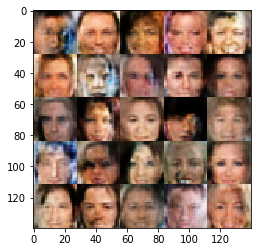

Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 1.5507
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.5777
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.9556
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.1577
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.9953
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.3810


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.